### Importing Libraries
This section imports necessary Python libraries for data analysis, visualization, and time series forecasting. We use:
- `pandas` for data manipulation
- `numpy` for numerical operations
- `matplotlib` and `seaborn` for visualizations
- `pmdarima` for automated ARIMA model selection
- `sklearn.metrics` for evaluating model performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

# Display settings
pd.options.display.float_format = '{:.2f}'.format

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Auto ARIMA for automated model selection
from pmdarima import auto_arima
import pmdarima as pm

# Display settings
pd.options.display.float_format = '{:.2f}'.format

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Loading the Dataset
The dataset is loaded from a CSV file using `pd.read_csv()`. We then check its structure using `.head()`, `.info()`, and `.describe()`.

In [3]:
# Load the merged dataset
data = pd.read_csv("merged_data.csv")
data.head()
data.head(10)

,Quantity,Transaction_Date,Total_Cost,Product_Name,Product_Price_y,Company_Name,Company_Profit
0,11.00,2024-03-26,1075200.00,RevenueVue Dashboard,179200.00,Elite Consulting 88,75950.00
1,16.00,NaN,1428000.00,EcoNomix Modeler,95200.00,Sky Industries 29,61952.00
2,6.00,NaN,940800.00,DashSync Analytics Hub,134400.00,NaN,NaN
3,12.00,NaN,1008000.00,BudgetMaster Pro,84000.00,Green Ventures 85,113470.00
4,8.00,NaN,705600.00,TrendWise Forecaster,100800.00,Green Industries 47,31130.00
5,4.00,2021-07-12,627200.00,OptiFlow Automation,156800.00,Green Partners 80,111227.00
6,14.00,2023-11-01,1960000.00,RiskRadar Monitor,151200.00,NaN,NaN
7,14.00,2023-11-01,1960000.00,SpendTrack Plus,106400.00,NaN,NaN
8,7.00,NaN,1792000.00,FinSphere Intelligence Suite,224000.00,Dynamic Enterprises 21,75301.50
9,14.00,NaN,1344000.00,FinPredictor Suite,140000.00,Dynamic Network 96,101428.00


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quantity          11000 non-null  float64
 1   Transaction_Date  2795 non-null   object 
 2   Total_Cost        11000 non-null  float64
 3   Product_Name      10106 non-null  object 
 4   Product_Price_y   10106 non-null  float64
 5   Company_Name      8937 non-null   object 
 6   Company_Profit    8937 non-null   float64
dtypes: float64(4), object(3)
memory usage: 601.7+ KB


In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,11000.00,10.56,5.52,0.00,6.00,11.00,15.00,21.00
Total_Cost,11000.00,1413456.29,859389.52,84000.00,756000.00,1344000.00,1881600.00,4480000.00
Product_Price_y,10106.00,134380.61,37105.27,84000.00,100800.00,134400.00,156800.00,224000.00
Company_Profit,8937.00,76299.73,25113.31,30663.00,55028.00,75301.50,99381.00,118114.00


In [9]:
data = data.drop(['Quantity','Total_Cost','Product_Name','Product_Price','Company_Name'], axis=1)
print(data)

       Transaction_ID  Company_ID  Product_ID Transaction_Date  \
0                1.00       88.00        6.00       2024-03-26   
1                2.00       29.00       19.00              NaN   
2                 NaN       28.00       18.00              NaN   
3                4.00       85.00       12.00              NaN   
4                5.00       47.00        3.00              NaN   
...               ...         ...         ...              ...   
20832         9997.00       39.00        2.00       2021-05-17   
20833             NaN       90.00        1.00              NaN   
20834         9999.00       33.00         NaN       2021-04-15   
20835         9999.00       33.00         NaN       2021-04-15   
20836             NaN       77.00       16.00              NaN   

       Revenue_per_Transaction  Company_Profit  \
0                          NaN        75950.00   
1                   1566895.89        61952.00   
2                    756573.29             NaN   
3      

### Feature Selection
Some columns that are not necessary for time series forecasting are dropped to simplify the model. Then we refresh and checked the data

In [9]:
# Convert date column to datetime and set as index
df1 = data.copy(deep=True)
df1['Transaction_Date'] = pd.to_datetime(df1['Transaction_Date'])
df1.set_index('Transaction_Date', inplace=True)

# Resample to weekly frequency
df1 = df1.resample('W').sum()
df1.head(10)

,Quantity,Total_Cost,Product_Name,Product_Price_y,Company_Name,Company_Profit
Transaction_Date,,,,,,
2020-11-01,55.00,9570400.00,DataBridge Integration ToolInsightMax Insights...,784000.00,Dynamic Enterprises 21Dynamic Ventures 73Pri...,414489.50
2020-11-08,124.00,17259200.00,CustomerScope InsightsInsightMax Insights Plat...,1450400.00,Global Solutions 100Innovative Corp 92Global...,644974.00
2020-11-15,85.00,10656800.00,Product 9FinPredictor SuiteFinPredictor SuiteO...,812000.00,Sky Associates 50Sky Consulting 64Pioneer Corp...,448130.50
2020-11-22,120.00,12644800.00,TrendWise ForecasterFinSphere Intelligence Sui...,1517600.00,Dynamic Network 96Innovative Consulting 19In...,626601.50
2020-11-29,186.00,22394400.00,SegmentX TargetingFinSphere Intelligence Suite...,1842400.00,Quantum Solutions 62Global Enterprises 9Global...,1329112.50
2020-12-06,25.00,5331200.00,OptiFlow AutomationDataBridge Integration Tool...,476000.00,Green Consulting 33Global Solutions 61Tech ...,194959.00
2020-12-13,126.00,17668000.00,EcoNomix ModelerBudgetMaster ProRevenueVue Das...,1736000.00,Tech Enterprises 1Elite Enterprises 81Tech C...,853914.50
2020-12-20,216.00,23133600.00,EcoNomix ModelerEcoNomix ModelerCustomerScope ...,2072000.00,Quantum Network 43Global Corp 48Prime Networ...,776263.00
2020-12-27,32.00,6165600.00,DataBridge Integration ToolFinSphere Intellige...,571200.00,Sky Consulting 64Quantum Associates 3Green Co...,257370.00


### Visualization
- Compare Company_Profit in data vs. df1.
- Analyze Company_Profit over time.

C:\Users\bmore\AppData\Local\Temp\ipykernel_12396\70059922.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Company_Profit']);
C:\Users\bmore\AppData\Local\Temp\ipykernel_12396\70059922.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['Company_Profit']);
C:\Users\bmore\AppData\Lo

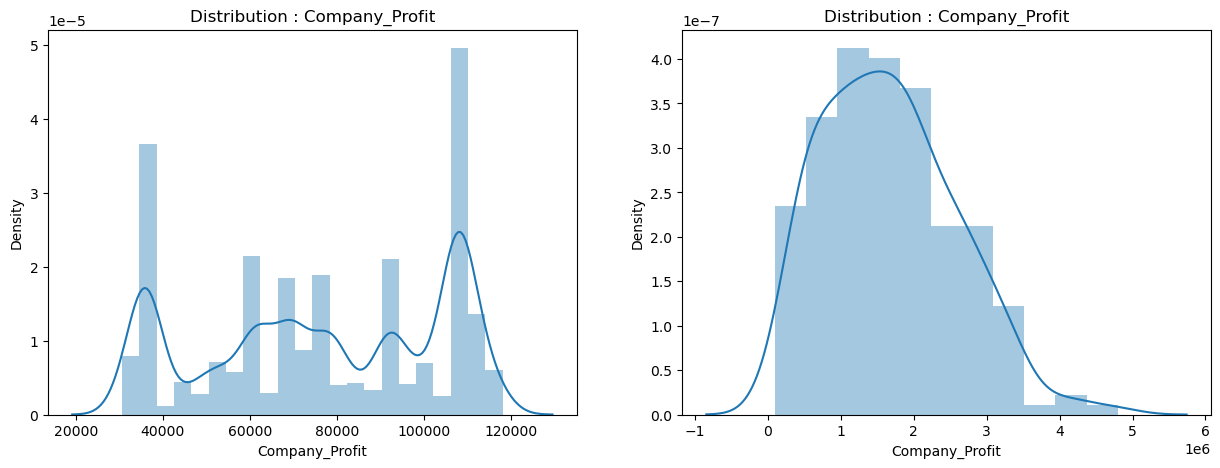

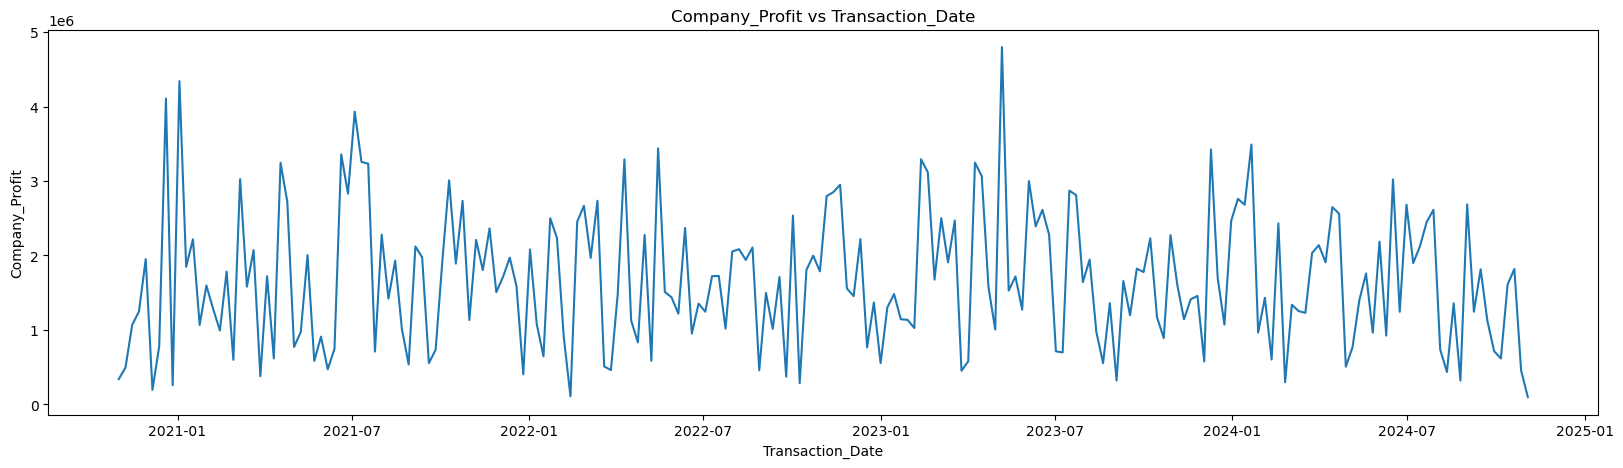

In [13]:
color1 = ['#296C92','#3EB489']
fig,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (15,5))

plt.subplot(1,2,1)
sns.distplot(data['Company_Profit']);
plt.title('Distribution : Company_Profit')

plt.subplot(1,2,2)
sns.distplot(df1['Company_Profit']);
plt.title('Distribution : Company_Profit')

fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize = (20,5))
plt.subplot(1,1,1)
sns.lineplot(x = df1.index ,y = 'Company_Profit',data = df1,palette = color1);
plt.title('Company_Profit vs Transaction_Date')

plt.show()
fig.tight_layout(pad = 2)

### Followup cleanups
Drops missing values while visualizing missing data patterns. 

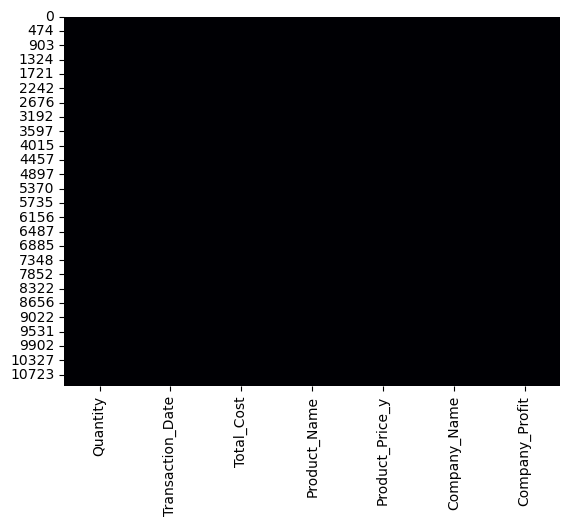

In [11]:
data = data.dropna()
data
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False); #This is to check missing datapoints

### Feature Selection
Some columns that are not necessary for time series forecasting are dropped to simplify the model. Decomposes Company_Profit into trend, seasonality, and residual components then visualizes the decomposition to identify patterns

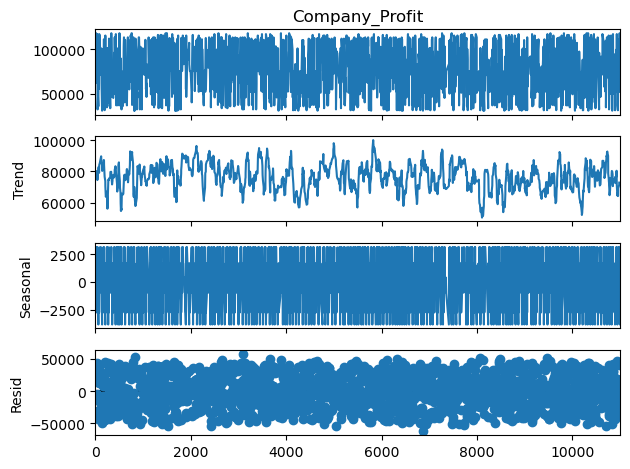

In [15]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

decomposition = sm.tsa.seasonal_decompose(data['Company_Profit'], period=12, model='additive')
decomposition.plot()
plt.show()

### Importing Libraries
This section imports necessary Python libraries for data analysis, visualization, and time series forecasting. We use:
- `pandas` for data manipulation
- `numpy` for numerical operations
- `matplotlib` and `seaborn` for visualizations
- `pmdarima` for automated ARIMA model selection
- `sklearn.metrics` for evaluating model performance.

In [17]:
# Fit Auto-ARIMA model
model = pm.auto_arima(data['Company_Profit'], seasonal=False, trace=True, suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=49484.063, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49075.427, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49482.064, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=48876.567, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=48737.663, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=48663.976, Time=0.22 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=48625.290, Time=0.26 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=48346.124, Time=0.72 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.61 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.90 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0] intercept
Total fi

### Auto-ARIMA Model
We use `auto_arima()` to automatically determine the best ARIMA parameters for the dataset. The model is trained and evaluated to ensure accurate forecasting.

In [23]:
# Forecast the next 6 months
n_months = 6
forecast_out, conf_int = model.predict(n_periods=n_months, return_conf_int=True)

# Generate monthly future dates
forecast_index_out = pd.date_range(start=df1.index[-1] + pd.DateOffset(months=1), periods=n_months, freq='M')

# Store forecasted values in a DataFrame
forecast_df = pd.DataFrame({'Date': forecast_index_out, 'Forecasted_Profit': forecast_out})

# Print forecasted profits
print("Forecasted Company Profits for the Next 6 Months:")
print(forecast_df)

Forecasted Company Profits for the Next 6 Months:
           Date  Forecasted_Profit
2090 2024-12-31           70711.16
2091 2025-01-31           74793.24
2092 2025-02-28           74060.80
2093 2025-03-31           74001.88
2094 2025-04-30           74042.76
2095 2025-05-31           73857.89


C:\Users\bmore\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\bmore\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\bmore\AppData\Local\Temp\ipykernel_14252\4000075276.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index_out = pd.date_range(start=df1.index[-1] + pd.DateOffset(months=1), periods=n_months, freq='M')


### Additional Checks
Checks if residuals meet key assumptions (normality, randomness, no autocorrelation)

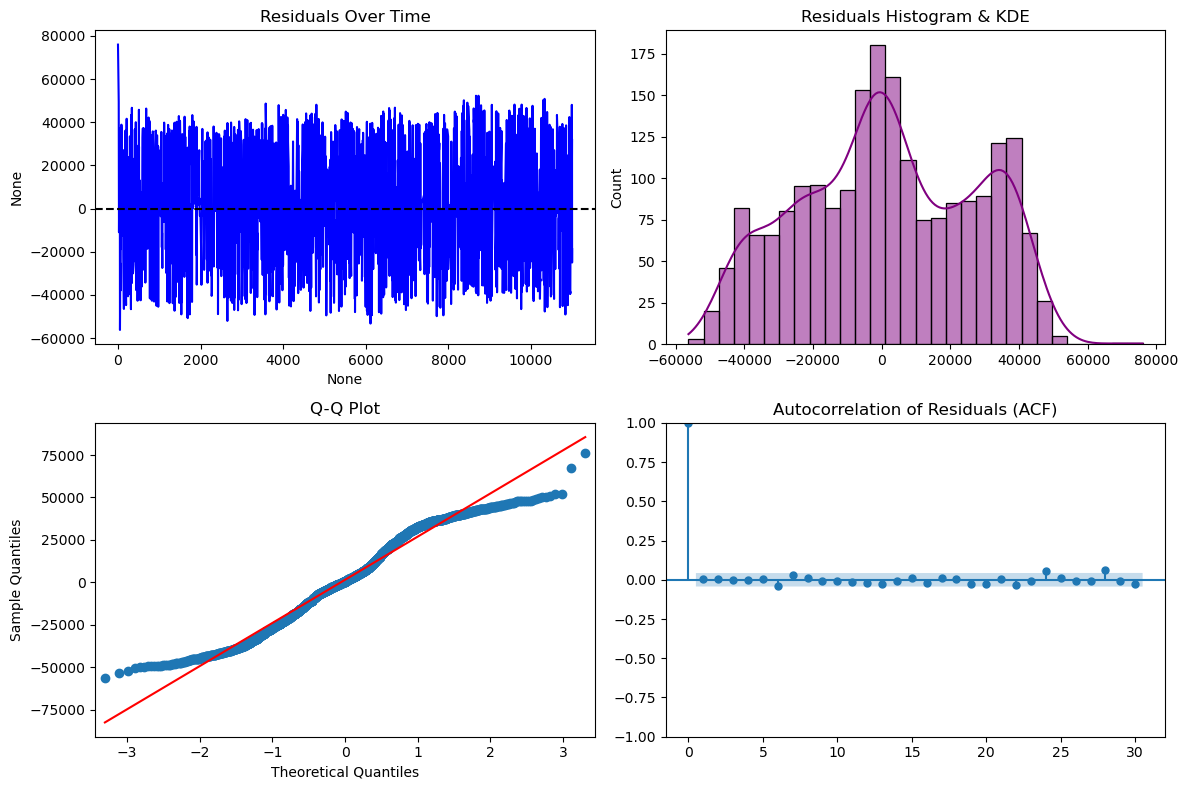

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Get residuals
residuals = model.resid()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residuals Over Time
sns.lineplot(x=data.index, y=residuals, ax=axes[0, 0], color='blue')
axes[0, 0].set_title("Residuals Over Time")
axes[0, 0].axhline(0, linestyle="--", color='black')

# Histogram & KDE of Residuals
sns.histplot(residuals, bins=30, kde=True, ax=axes[0, 1], color='purple')
axes[0, 1].set_title("Residuals Histogram & KDE")

# Q-Q Plot for Normality
sm.qqplot(residuals, line='s', ax=axes[1, 0])
axes[1, 0].set_title("Q-Q Plot")

# Autocorrelation (ACF) Plot
sm.graphics.tsa.plot_acf(residuals, lags=30, ax=axes[1, 1])
axes[1, 1].set_title("Autocorrelation of Residuals (ACF)")

plt.tight_layout()
plt.show()

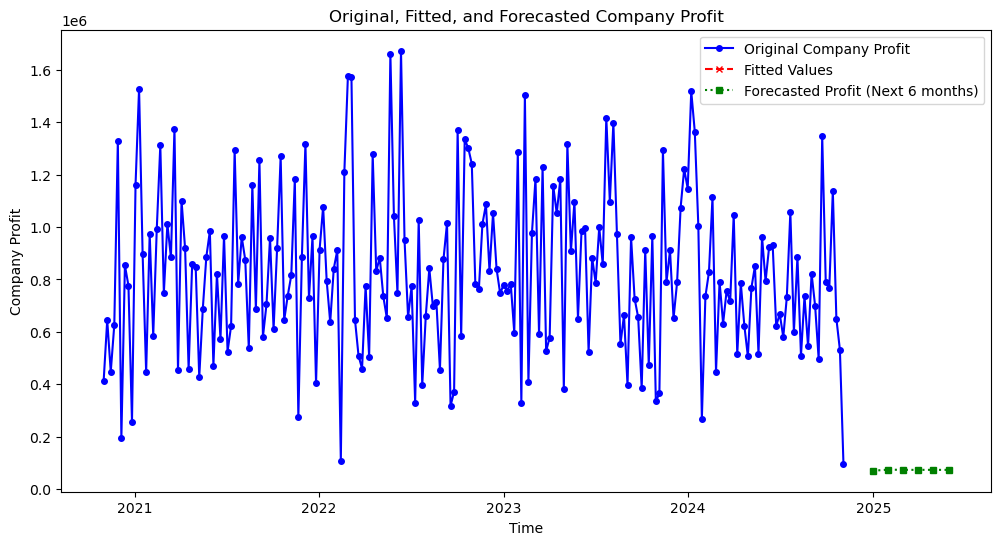

In [33]:
import matplotlib.pyplot as plt

# Get fitted values from the model
fitted_values = model.predict_in_sample()

# Ensure index consistency
df1['Fitted_Values'] = fitted_values

# Plot original, fitted, and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df1.index, df1['Company_Profit'], label='Original Company Profit', color='blue', marker='o', markersize=4)
plt.plot(df1.index, df1['Fitted_Values'], color='red', linestyle='dashed', label='Fitted Values', marker='x', markersize=4)
plt.plot(forecast_index_out, forecast_out, label='Forecasted Profit (Next 6 months)', color='green', linestyle='dotted', marker='s', markersize=4)

plt.xlabel("Time")
plt.ylabel("Company Profit")
plt.title("Original, Fitted, and Forecasted Company Profit")
plt.legend()
plt.show()


### Forecast
Forecasted Company Profits for the Next 6 Months:
| Month      | Forecasted MTD Profit  |
|------------|--------------------------|
| December   | 70,711.16                 |
| January    | 74,793.24                 |
| February   | 74,060.80                 |
| March      | 74,001.88                 |
| April      | 74,042.76                 |
| May        | 73,857.89                 |
